In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import normalize
from scipy.stats import randint as sp_randint
import matplotlib.pyplot as plt


/Users/arshanrahman/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/arshanrahman/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
INPUT_DATA = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

TRAINING_SIZE = 1000
TESTING_SIZE = 300

'''
COLUMNS = ['gx','gy','gz', 'tax', 'tay', 'taz']

X_train = pd.DataFrame(COLUMNS)
for i in range(0,6):
    X_train[i] = pd.read_csv('data/train/'+INPUT_DATA[3+i]+'train.txt', sep=" ", header=None)
    X_test[i] = pd.read_csv('data/test/'+INPUT_DATA[3+i]+'test.txt', sep=" ", header=None)



#X_train = pd.read_csv('data/X_train.txt', sep=" ", header=None)
Y_train = pd.read_csv('data/Y_train.txt', sep=" ", header=None)

#X_test = pd.read_csv('data/X_test.txt', sep=" ", header=None)
Y_test = pd.read_csv('data/Y_test.txt', sep=" ", header=None)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

X_train.head()
Y_train.head()

X = X_train[0:1000]
Y = Y_train[0:1000]
Xt = X_test[0:300]
Yt = Y_test[0:300]

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)
'''

'\nCOLUMNS = [\'gx\',\'gy\',\'gz\', \'tax\', \'tay\', \'taz\']\n\nX_train = pd.DataFrame(COLUMNS)\nfor i in range(0,6):\n    X_train[i] = pd.read_csv(\'data/train/\'+INPUT_DATA[3+i]+\'train.txt\', sep=" ", header=None)\n    X_test[i] = pd.read_csv(\'data/test/\'+INPUT_DATA[3+i]+\'test.txt\', sep=" ", header=None)\n\n\n\n#X_train = pd.read_csv(\'data/X_train.txt\', sep=" ", header=None)\nY_train = pd.read_csv(\'data/Y_train.txt\', sep=" ", header=None)\n\n#X_test = pd.read_csv(\'data/X_test.txt\', sep=" ", header=None)\nY_test = pd.read_csv(\'data/Y_test.txt\', sep=" ", header=None)\n\nprint(X_train.shape)\nprint(Y_train.shape)\nprint(X_test.shape)\nprint(Y_test.shape)\n\nX_train.head()\nY_train.head()\n\nX = X_train[0:1000]\nY = Y_train[0:1000]\nXt = X_test[0:300]\nYt = Y_test[0:300]\n\nprint(X.shape)\nprint(Y.shape)\nprint(Xt.shape)\nprint(Yt.shape)\n'

In [3]:

def feature_extraction(x, y, z):
    features = [np.mean(x), np.mean(y), np.mean(z), np.std(x), np.std(y), np.std(z)]
    #Median Absolute Deviation
    features.extend((np.mean(abs(x - features[0])), np.mean(abs(y - features[1])), np.mean(abs(z - features[2]))))
    #Jerk Signals
    features.extend((np.mean(np.diff(x)), np.mean(np.diff(y)), np.mean(np.diff(z)), np.std(np.diff(x)), np.std(np.diff(y)), np.std(np.diff(z))))
    features.extend((np.mean(abs(np.diff(x) - features[9])), np.mean(abs(np.diff(y) - features[10])), np.mean(abs(np.diff(y) - features[11]))))
    #features.extend((max(x), max(y), max(z), min(x), min(y), min(z)))
    return features

def feature_selection(X):
    data = []
    for i in range(X.shape[0]):
        features = []
        for j in range(0, X.shape[2], 3):
            x = [X[i][u][j] for u in range(X.shape[1])]
            y = [X[i][u][j+1] for u in range(X.shape[1])]
            z = [X[i][u][j+2] for u in range(X.shape[1])]
            features.append(feature_extraction(x, y, z))
        data.append(normalize(features))
    return data

In [4]:

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in 
             [row.replace('  ', ' ').strip().split(' ') for row in file]
            ]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))


def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_


X_train_input_paths = ["data/train/" + signal + "train.txt" for signal in INPUT_DATA]
X_test_input_paths = ["data/test/" + signal + "test.txt" for signal in INPUT_DATA]
X_train = load_X(X_train_input_paths)
X_test = load_X(X_test_input_paths)

y_train_path = "data/y_train.txt"
y_test_path = "data/y_test.txt"
Y_train = load_y(y_train_path).ravel()
Y_test = load_y(y_test_path).ravel()

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

print(X_train[0])
print(Y_train[0])

X = X_train[0:TRAINING_SIZE]
Y = Y_train[0:TRAINING_SIZE]
Xt = X_test[0:TESTING_SIZE]
Yt = Y_test[0:TESTING_SIZE]

print(X.shape)
print(Y.shape)
print(Xt.shape)
print(Yt.shape)

X = np.array(feature_selection(X))
Xt = np.array(feature_selection(Xt))

print(X.shape)
print(Xt.shape)

print(X[0])
#print(Xt[0])

np.savetxt("data/test_data_format.csv", X[0], fmt='%5s', delimiter=",")


(7352, 128, 9)
(7352,)
(2947, 128, 9)
(2947,)
[[  1.80851493e-04   1.07668098e-02   5.55606782e-02 ...,   1.01281703e+00
   -1.23216704e-01   1.02934100e-01]
 [  1.01385601e-02   6.57948013e-03   5.51248305e-02 ...,   1.02283299e+00
   -1.26875594e-01   1.05687201e-01]
 [  9.27557424e-03   8.92887823e-03   4.84047309e-02 ...,   1.02202797e+00
   -1.24003701e-01   1.02102503e-01]
 ..., 
 [ -1.14748406e-03   1.71443899e-04   2.64786393e-03 ...,   1.01844501e+00
   -1.24069601e-01   1.00385197e-01]
 [ -2.22265502e-04   1.57418102e-03   2.38105701e-03 ...,   1.01937199e+00
   -1.22745097e-01   9.98735502e-02]
 [  1.57550001e-03   3.07018892e-03  -2.26975698e-03 ...,   1.02117097e+00
   -1.21325999e-01   9.49874073e-02]]
5
(1000, 128, 9)
(1000,)
(300, 128, 9)
(300,)
(1000, 3, 18)
(300, 3, 18)
[[  8.77741983e-02  -6.40452583e-02  -3.14372406e-01   1.13786540e-01
    1.77998177e-01   7.15922028e-01   9.71394559e-02   1.40047414e-01
    5.13833336e-01   4.24865816e-04  -2.34470271e-03  -1.7617

In [5]:
#Logistic Regression

penalty = ["l1", "l2"]
np.random.seed(121)
C_range = np.random.normal(1, 0.2, 10).astype(float)

# Check that C>0 
C_range[C_range < 0] = 0.0001

hyperparameters = {'penalty': penalty, 
                    'C': C_range}

print (hyperparameters)

clf = RandomizedSearchCV(LogisticRegression(), param_distributions=hyperparameters, cv=3, scoring='accuracy')
clf.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

best_penalty = clf.best_params_['penalty']
best_C = clf.best_params_['C']

print ("The best performing penalty is: {}".format(best_penalty))
print ("The best performing C value is: {:5.2f}".format(best_C))

# examine the best model
print("Best score")
print(clf.best_score_)
print("Best parameters set found on training set:")
print(clf.best_params_)
print()
print(clf.grid_scores_)
print()

Y_pred = clf.predict(Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2]))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))


{'penalty': ['l1', 'l2'], 'C': array([ 0.95759337,  0.94301417,  0.88522036,  0.91193797,  0.93397789,
        1.23673891,  1.32307459,  1.07341249,  0.99717614,  1.12592836])}
The best performing penalty is: l1
The best performing C value is:  1.32
Best score
0.841
Best parameters set found on training set:
{'penalty': 'l1', 'C': 1.3230745856698762}

[mean: 0.84000, std: 0.06805, params: {'penalty': 'l1', 'C': 0.99717613800052618}, mean: 0.82400, std: 0.06151, params: {'penalty': 'l2', 'C': 1.0734124939596197}, mean: 0.82400, std: 0.05927, params: {'penalty': 'l2', 'C': 0.95759336690378638}, mean: 0.83900, std: 0.06782, params: {'penalty': 'l1', 'C': 0.95759336690378638}, mean: 0.82500, std: 0.05989, params: {'penalty': 'l2', 'C': 0.88522035823829193}, mean: 0.84100, std: 0.07399, params: {'penalty': 'l1', 'C': 1.3230745856698762}, mean: 0.82400, std: 0.06151, params: {'penalty': 'l2', 'C': 1.1259283594817016}, mean: 0.83900, std: 0.06782, params: {'penalty': 'l1', 'C': 0.943014166041

Precision: 84.0607522558742%
Recall: 76.66666666666667%
f1_score: 73.42779589322753%

Confusion Matrix:
[[58  1  0  0  0  0]
 [ 8 38  0  0  0  0]
 [16  6 25  0  0  0]
 [ 0  0  0  8 38  0]
 [ 0  1  0  0 53  0]
 [ 0  0  0  0  0 48]]

Confusion matrix (normalised to % of total test data):
[[ 19.33333206   0.33333334   0.           0.           0.           0.        ]
 [  2.66666675  12.66666603   0.           0.           0.           0.        ]
 [  5.33333349   2.           8.33333397   0.           0.           0.        ]
 [  0.           0.           0.           2.66666675  12.66666603   0.        ]
 [  0.           0.33333334   0.           0.          17.66666603   0.        ]
 [  0.           0.           0.           0.           0.          16.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


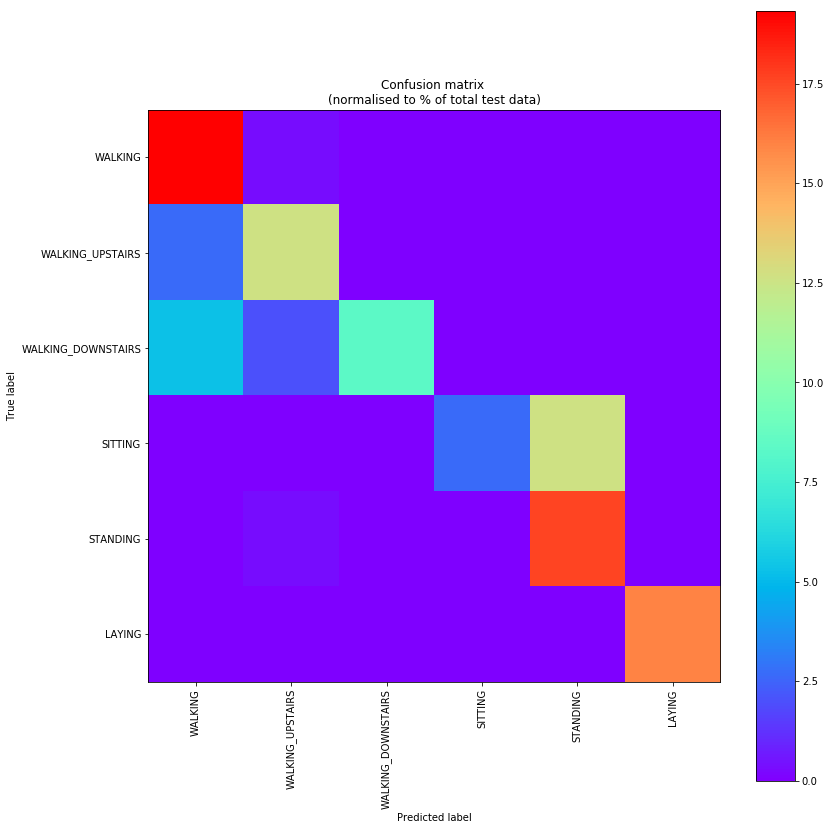

In [6]:

print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [7]:
#KNN


# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_dist = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_dist, cv=4, scoring='accuracy')
grid.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

#print(grid.grid_scores_)
#grid_mean_scores = [result.mean_validation_score for result in grid.grid_scores_]
#print(grid_mean_scores)
print(grid.best_score_)
print(grid.best_params_)

# plot the results
#plt.plot(k_range, grid_mean_scores)
#plt.xlabel('Value of K for KNN')
#plt.ylabel('Cross-Validated Accuracy')


rand = RandomizedSearchCV(knn, param_dist, cv=4, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

#print(rand.grid_scores_)
#rand_mean_scores = [result.mean_validation_score for result in rand.grid_scores_]
#print(rand_mean_scores)
print(rand.best_score_)
print(rand.best_params_)

#plt.plot(k_range, rand_mean_scores)
#plt.xlabel('Value of K for KNN')
#plt.ylabel('Cross-Validated Accuracy')


0.914
{'n_neighbors': 1, 'weights': 'uniform'}
0.898
{'weights': 'distance', 'n_neighbors': 10}


In [8]:
Y_pred = grid.predict(Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2]))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

Y_pred1 = rand.predict(Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2]))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred1))
print(metrics.confusion_matrix(Yt, Y_pred1))


Accuracy Rate:
0.816666666667
[[56  2  1  0  0  0]
 [ 0 45  1  0  0  0]
 [ 7 23 17  0  0  0]
 [ 0  0  0 25 21  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]]
Accuracy Rate:
0.836666666667
[[56  3  0  0  0  0]
 [ 2 44  0  0  0  0]
 [ 6 25 16  0  0  0]
 [ 0  0  0 33 13  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]]


Precision: 85.6495015316068%
Recall: 81.66666666666667%
f1_score: 79.88979311117632%

Confusion Matrix:
[[56  2  1  0  0  0]
 [ 0 45  1  0  0  0]
 [ 7 23 17  0  0  0]
 [ 0  0  0 25 21  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]]

Confusion matrix (normalised to % of total test data):
[[ 18.66666603   0.66666669   0.33333334   0.           0.           0.        ]
 [  0.          15.00000095   0.33333334   0.           0.           0.        ]
 [  2.33333325   7.66666698   5.66666698   0.           0.           0.        ]
 [  0.           0.           0.           8.33333397   7.           0.        ]
 [  0.           0.           0.           0.          18.           0.        ]
 [  0.           0.           0.           0.           0.          16.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


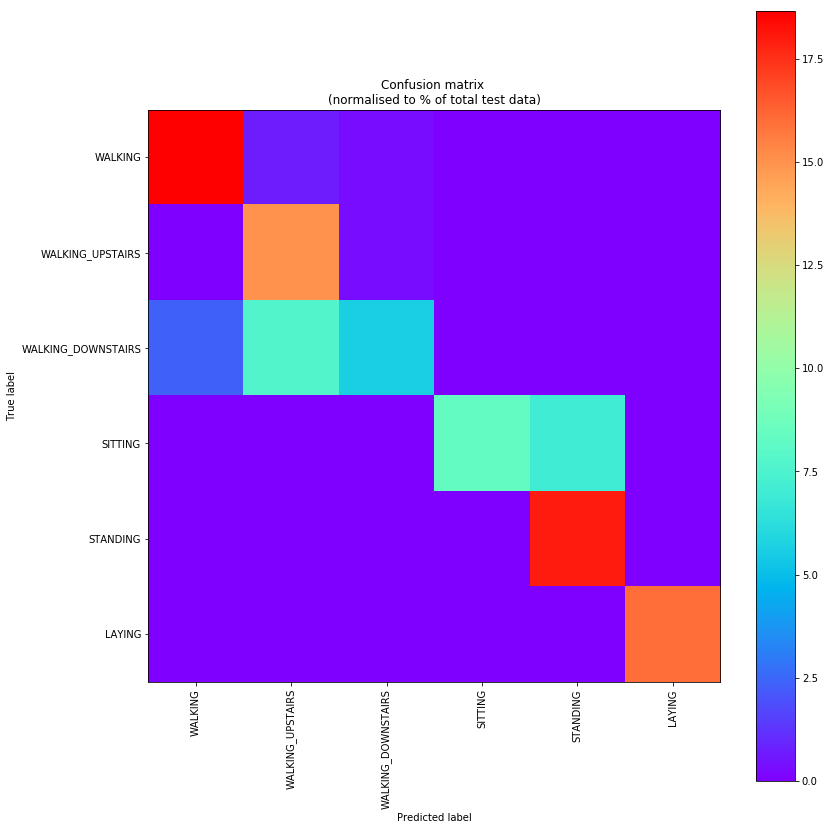

In [9]:
print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
#SVM

param_dist = {
    'kernel': ['rbf'],
    'gamma': np.logspace(-4, 2, 3),
    'C': np.logspace(-4, 2, 5),
}
svm = SVC(probability=True)
clf = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_dist,
    cv=5,
)
clf.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))

best_gamma  = clf.best_params_['gamma']
best_C      = clf.best_params_['C']

print("The best performing gamma value is: {:5.2f}".format(best_gamma))
print("The best performing C value is: {:5.2f}".format(best_C))

print("Best score")
print(clf.best_score_)
print("Best parameters set found on training set:")
print(clf.best_params_)
print()
print(clf.grid_scores_)
print()
    
svm = SVC(kernel='rbf', C=clf.best_params_['C'], gamma=clf.best_params_['gamma'])
svm.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

Y_pred = svm.predict(Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2]))
print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

0.349 (+/-0.177) for {'kernel': 'rbf', 'gamma': 100.0, 'C': 3.1622776601683795}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 0.0031622776601683794}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 100.0, 'C': 0.0031622776601683794}
0.349 (+/-0.177) for {'kernel': 'rbf', 'gamma': 100.0, 'C': 100.0}
0.549 (+/-0.029) for {'kernel': 'rbf', 'gamma': 0.10000000000000001, 'C': 0.10000000000000001}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 0.0001, 'C': 3.1622776601683795}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 0.10000000000000001, 'C': 0.0031622776601683794}
0.948 (+/-0.125) for {'kernel': 'rbf', 'gamma': 0.10000000000000001, 'C': 100.0}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 100.0, 'C': 0.0001}
0.209 (+/-0.001) for {'kernel': 'rbf', 'gamma': 100.0, 'C': 0.10000000000000001}
The best performing gamma value is:  0.10
The best performing C value is: 100.00
Best score
0.948
Best parameters set found on training set:
{'kernel': 'rbf', 'gamma': 0.1000000000000

Precision: 78.97528828887303%
Recall: 74.33333333333333%
f1_score: 70.53259037764987%

Confusion Matrix:
[[59  0  0  0  0  0]
 [ 0 33 13  0  0  0]
 [12 13 22  0  0  0]
 [ 0  0  0  7 39  0]
 [ 0  0  0  0 54  0]
 [ 0  0  0  0  0 48]]

Confusion matrix (normalised to % of total test data):
[[ 19.66666794   0.           0.           0.           0.           0.        ]
 [  0.          11.           4.33333349   0.           0.           0.        ]
 [  4.           4.33333349   7.33333302   0.           0.           0.        ]
 [  0.           0.           0.           2.33333325  13.           0.        ]
 [  0.           0.           0.           0.          18.           0.        ]
 [  0.           0.           0.           0.           0.          16.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


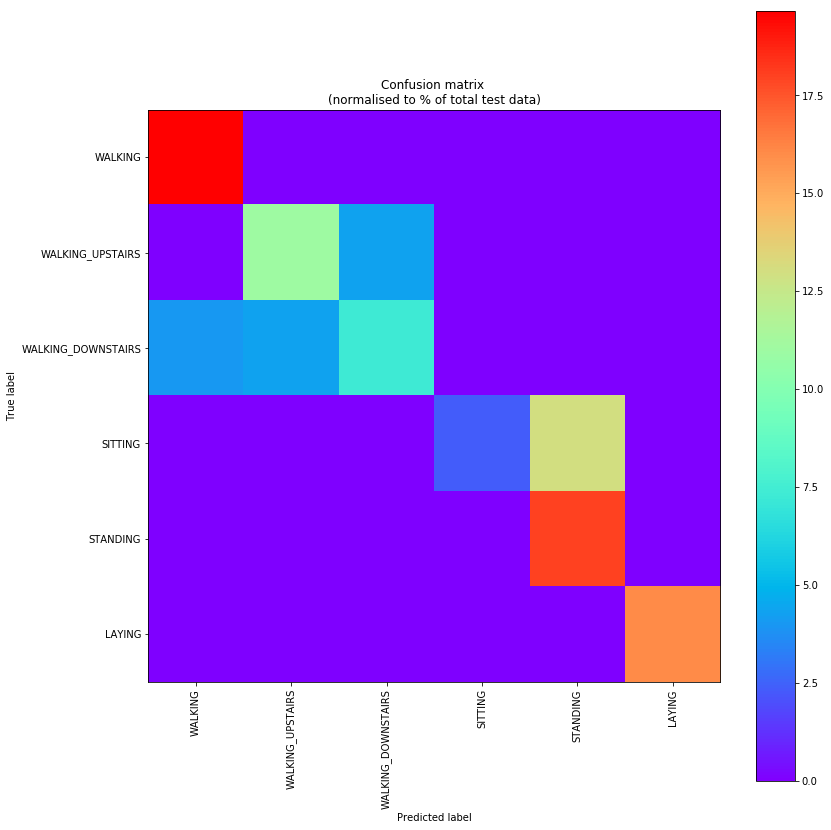

In [11]:
print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [12]:
#Random Forest



param_dist = {
    "max_depth": [20, 25, 30, 35],
    "max_features": sp_randint(1, min(300, X.shape[1])),
    "min_samples_split": sp_randint(2, 20),
    "min_samples_leaf": sp_randint(2, 20),
    'n_estimators': [50, 100, 200, 250, 300],
    'bootstrap': [True, False],
}

r_forest = RandomForestClassifier(random_state=1)
n_iter_search = 15
clf = RandomizedSearchCV(
    estimator=r_forest,
    param_distributions=param_dist,
    n_iter=n_iter_search,
    cv=5,
    random_state=1,
)

clf.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)

for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
    
print("Best score")
print(clf.best_score_)
print("Best parameters set found on training set:")
print(clf.best_params_)
print()
print(clf.grid_scores_)
print()

r_forest = RandomForestClassifier(bootstrap=clf.best_params_['bootstrap'], max_depth=clf.best_params_['max_depth'], max_features=clf.best_params_['max_features'], 
                            min_samples_leaf= clf.best_params_['min_samples_leaf'], min_samples_split= clf.best_params_['min_samples_split'],
                           n_estimators = clf.best_params_['n_estimators'])
    
#r_forest = RandomForestClassifier(bootstrap=False, max_depth=25, max_features=23, min_samples_leaf= 3, min_samples_split= 2, n_estimators = 250)
r_forest.fit(X.reshape(X.shape[0], X.shape[1]*X.shape[2]), Y)
Y_pred = r_forest.predict(Xt.reshape(Xt.shape[0], Xt.shape[1]*Xt.shape[2]))

print("Accuracy Rate:")
print(metrics.accuracy_score(Yt, Y_pred))
print(metrics.confusion_matrix(Yt, Y_pred))

0.883 (+/-0.144) for {'bootstrap': False, 'max_depth': 35, 'max_features': 1, 'min_samples_leaf': 13, 'min_samples_split': 16, 'n_estimators': 300}
0.899 (+/-0.182) for {'bootstrap': True, 'max_depth': 35, 'max_features': 2, 'min_samples_leaf': 13, 'min_samples_split': 14, 'n_estimators': 100}
0.884 (+/-0.196) for {'bootstrap': False, 'max_depth': 25, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 50}
0.884 (+/-0.201) for {'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'min_samples_leaf': 15, 'min_samples_split': 9, 'n_estimators': 300}
0.885 (+/-0.168) for {'bootstrap': False, 'max_depth': 25, 'max_features': 1, 'min_samples_leaf': 9, 'min_samples_split': 18, 'n_estimators': 300}
0.892 (+/-0.204) for {'bootstrap': True, 'max_depth': 25, 'max_features': 2, 'min_samples_leaf': 12, 'min_samples_split': 6, 'n_estimators': 200}
0.869 (+/-0.158) for {'bootstrap': True, 'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 14, 'min_samples_split':

Precision: 85.59656339832294%
Recall: 83.66666666666667%
f1_score: 82.76898087323048%

Confusion Matrix:
[[59  0  0  0  0  0]
 [ 3 43  0  0  0  0]
 [15  4 28  0  0  0]
 [ 0  0  0 24 20  2]
 [ 0  0  0  5 49  0]
 [ 0  0  0  0  0 48]]

Confusion matrix (normalised to % of total test data):
[[ 19.66666794   0.           0.           0.           0.           0.        ]
 [  1.          14.33333302   0.           0.           0.           0.        ]
 [  5.           1.33333337   9.33333302   0.           0.           0.        ]
 [  0.           0.           0.           8.           6.66666698
    0.66666669]
 [  0.           0.           0.           1.66666675  16.33333206   0.        ]
 [  0.           0.           0.           0.           0.          16.        ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more than a 6th of the data is correctly classifier in the last category.


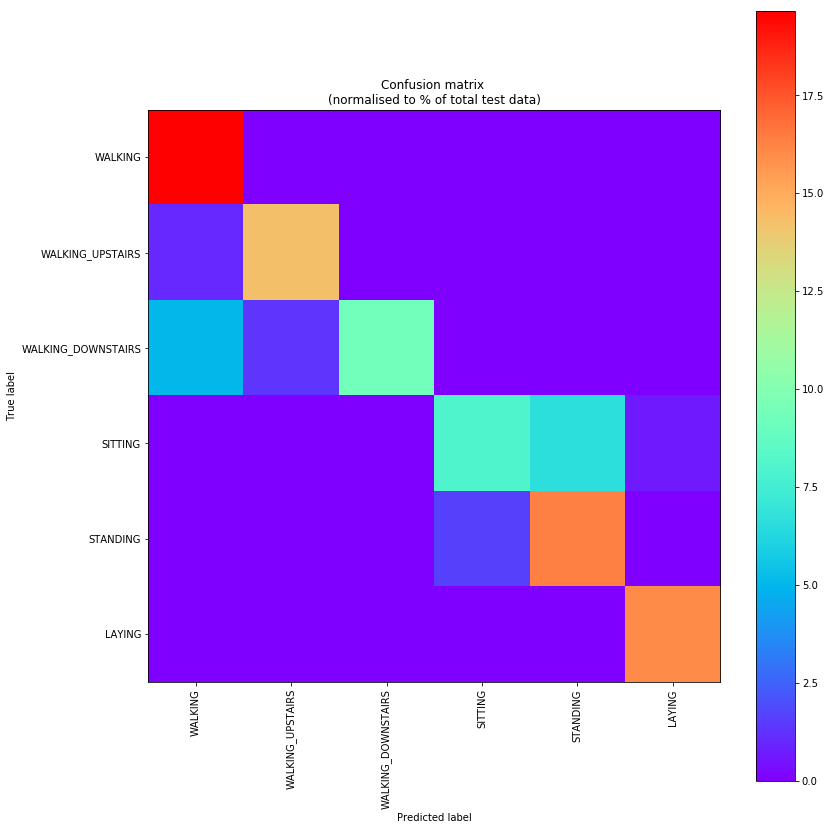

In [13]:

print("Precision: {}%".format(100*metrics.precision_score(Yt, Y_pred, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(Yt, Y_pred, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(Yt, Y_pred, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(Yt, Y_pred)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()